<a href="https://colab.research.google.com/github/anirbrhm/lenet5-mnist/blob/main/Implementation_of_LeNet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Recognition using LeNet-5 

In [1]:
import torch 
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
import torchvision
import torchvision.transforms as transforms

## Data Loading 

In [3]:
# adding this as downloading the dataset directly shows 403 error 
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [4]:
trainset = torchvision.datasets.MNIST(root = "./data", train = True, download = True,transform=transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
classes = ("0","1","2","3","4","5","6","7","8","9") 

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True) # gives me 4 images everytime, shuffle means randomly. 

In [7]:
dataiter = iter(trainloader) # create an iterator 
images, labels = dataiter.next() # gives me one instance of trainloader (4 images) 

print(images.shape) 

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
3


The images are 1x28x28 shaped images.

## Visualize Data

In [8]:
img = images[1]
print(type(img))

<class 'torch.Tensor'>


In [9]:
npimg = img.numpy()
print(npimg.shape) # in the shape of (z,x,y) , but to plot it we need (x,y,z) 

(1, 28, 28)


In [10]:
npimg = np.transpose(npimg, (1,2,0)).reshape(28,28) # for higher dimension matrices , transpose is any permutation. 
print(npimg.shape)

(28, 28)


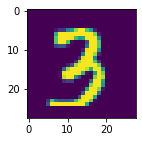

In [11]:
plt.figure(figsize=(2,2))
plt.imshow(npimg) # image plotting on matplotlib
plt.show()

We can automate this process by programming a function to do this for us

In [12]:
def imshow(img):
  npimg = img.numpy()
  plt.figure(figsize=(2,2))
  plt.imshow(np.transpose(npimg,(1,2,0)).reshape(28,28)) 
  plt.show()

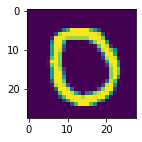

0


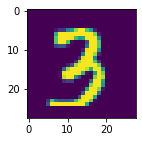

3


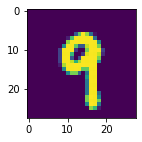

9


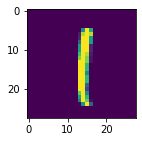

1


In [13]:
for i in range(4):
  imshow(images[i]) 
  print(classes[labels[i]])

## LeNet Architecture

In [14]:
import torch.nn as nn 

In [21]:
class LeNet(nn.Module) : 
  def __init__(self):
    super(LeNet,self).__init__()
    self.cnn_model = nn.Sequential(
        nn.Conv2d(1,6,5), # (N,1,28,28) -> (N,6,24,24) 
        nn.Tanh(), # (N,6,24,24) -> (N,6,24,24) 
        nn.AvgPool2d(2,stride = 2), # (N,6,24,24) -> (N,6,12,12)
        nn.Conv2d(6,16,5), # (N,6,12,12) -> (N,16,8,8) 
        nn.Tanh(), # (N,16,8,8) -> (N,16,8,8) 
        nn.AvgPool2d(2, stride = 2), # (N,16,8,8) -> (N,16,4,4) 
    ) 
    # we flatten the tensor here to be a 256 dimensional vector 

    self.fc_model = nn.Sequential( 
        nn.Linear(256,120), # (N, 256) -> (N, 120) 
        nn.Tanh(), 
        nn.Linear(120,84), # (N, 120) -> (N, 84)
        nn.Tanh(), 
        nn.Linear(84,10), # (N, 84) -> (N, 10) 
        nn.Softmax(1) # along the right dimension
        )

  def forward(self,x):
    # print(x.shape) 
    x = self.cnn_model(x) 
    # print(x.shape) 
    x = x.view(x.size(0),-1)
    # print(x.shape) 
    x = self.fc_model(x) 
    # print(x.shape)
    return x 

Loading the whole MNIST Data Set

In [22]:
batch_size = 128 
trainset = torchvision.datasets.MNIST(root = "./data", train = True, download = True,transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.MNIST(root = "./data", train = False, download = True,transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False) # no need for shuffling  

## Move to GPU

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)

cuda:0


In [24]:
def evaluation(dataloader):
  total , correct = 0 , 0 
  for data in dataloader:
    inputs, labels = data 
    inputs, labels = inputs.to(device), labels.to(device) 
    outputs = net(inputs) 
    _, pred = torch.max(outputs.data, 1) 
    total += labels.size(0) 
    correct += (pred == labels).sum().item()
  return 100 * correct / total 

In [25]:
import torch.optim as optim 

net = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss() 
opt = optim.Adam(net.parameters())

In [26]:
%time 

max_epochs = 16 

for epoch in range(max_epochs):
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data 
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()

    outputs = net(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

  print("Epoch : %d/%d" %(epoch,max_epochs))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs
Epoch : 0/16
Epoch : 1/16
Epoch : 2/16
Epoch : 3/16
Epoch : 4/16
Epoch : 5/16
Epoch : 6/16
Epoch : 7/16
Epoch : 8/16
Epoch : 9/16
Epoch : 10/16
Epoch : 11/16
Epoch : 12/16
Epoch : 13/16
Epoch : 14/16
Epoch : 15/16


In [27]:
print("Test acc : %0.2f, Train acc : %0.2f" %(evaluation(testloader),evaluation(trainloader)))

Test acc : 98.52, Train acc : 99.30
